In [ ]:
import tensorflow as tf
import os
import json
import pandas as pd
import re
import numpy as np
import time
import matplotlib.pyplot as plt
import collections
import random
import requests
import json
from math import sqrt
from PIL import Image
from tqdm.auto import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
wbc_path = "/content/drive/My Drive/wbc_new_dataset/bccd_wbc"

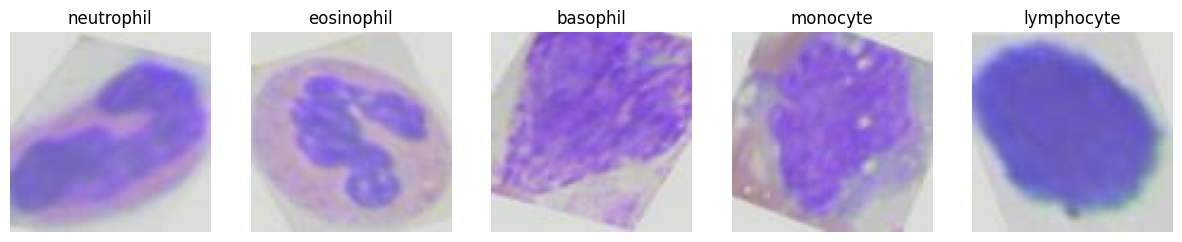

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Initialize Matplotlib figure and axis
fig, axs = plt.subplots(1, 5, figsize=(15, 3))

# Iterate over each subfolder (class)
for i, class_folder in enumerate(os.listdir(wbc_path)):
    class_folder_path = os.path.join(wbc_path, class_folder)

    # Check if it's a directory
    if os.path.isdir(class_folder_path):
        # Iterate over each file in the class folder
        for file_name in os.listdir(class_folder_path):
            # Construct the full file path
            file_path = os.path.join(class_folder_path, file_name)

            # Load the image using Matplotlib
            image = mpimg.imread(file_path)

            # Display the image in the corresponding subplot
            axs[i].imshow(image)
            axs[i].set_title(class_folder)
            axs[i].axis('off')
            break  # Show only the first image from each class
plt.show()


# **Histogram equalization**

In [ ]:
import os
import cv2

# Define the main folder path
main_folder_path = "/content/drive/My Drive/wbc_new_dataset/bccd_wbc"

# Define the output folder path for equalized images
output_folder_path = "/content/drive/My Drive/equalized_images"

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)

# Iterate over each subfolder (class)
for class_folder in os.listdir(main_folder_path):
    class_folder_path = os.path.join(main_folder_path, class_folder)

    # Check if it's a directory
    if os.path.isdir(class_folder_path):
        # Create a subfolder in the output directory for the class
        output_class_folder_path = os.path.join(output_folder_path, class_folder)
        if not os.path.exists(output_class_folder_path):
            os.makedirs(output_class_folder_path)

        # Iterate over each file in the class folder
        for file_name in os.listdir(class_folder_path):
            # Construct the full file path
            file_path = os.path.join(class_folder_path, file_name)

            # Read the image using OpenCV
            image = cv2.imread(file_path)

            # Convert the image to grayscale if it's in color
            if len(image.shape) > 2:
                gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            else:
                gray_image = image

            # Perform histogram equalization
            equalized_image = cv2.equalizeHist(gray_image)

            # Write the equalized image to the output folder
            output_file_path = os.path.join(output_class_folder_path, file_name)
            cv2.imwrite(output_file_path, equalized_image)


# **Image filtering (Gaussian Filter)**

In [ ]:
import os
import cv2

# Define the main folder path
main_folder_path = "/content/drive/My Drive/equalized_images"

# Define the output folder path for filtered images
output_folder_path = "/content/drive/My Drive/filtered_images"

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)

# Define the parameters for the Gaussian filter
kernel_size = (5, 5)  # Kernel size for blurring
sigma_x = 0  # Standard deviation in X direction

# Iterate over each subfolder (class)
for class_folder in os.listdir(main_folder_path):
    class_folder_path = os.path.join(main_folder_path, class_folder)

    # Check if it's a directory
    if os.path.isdir(class_folder_path):
        # Create a subfolder in the output directory for the class
        output_class_folder_path = os.path.join(output_folder_path, class_folder)
        if not os.path.exists(output_class_folder_path):
            os.makedirs(output_class_folder_path)

        # Iterate over each file in the class folder
        for file_name in os.listdir(class_folder_path):
            # Construct the full file path
            file_path = os.path.join(class_folder_path, file_name)

            # Read the image using OpenCV
            image = cv2.imread(file_path)

            # Apply Gaussian filter to the image
            filtered_image = cv2.GaussianBlur(image, kernel_size, sigma_x)

            # Write the filtered image to the output folder
            output_file_path = os.path.join(output_class_folder_path, file_name)
            cv2.imwrite(output_file_path, filtered_image)


In [ ]:
import os
import pandas as pd

data_path = "/content/drive/My Drive/filtered_images"

# Initialize empty lists to store file paths and labels
file_paths = []
labels = []

# Iterate over each subfolder (class)
for class_folder in os.listdir(data_path):
    class_folder_path = os.path.join(data_path, class_folder)

    # Check if it's a directory
    if os.path.isdir(class_folder_path):
        # Iterate over each file in the class folder
        for file_name in os.listdir(class_folder_path):
            # Construct the full file path
            file_path = os.path.join(class_folder_path, file_name)

            # Append the file path to the list
            file_paths.append(file_path)

            # Append the corresponding label to the list
            labels.append(class_folder)

# Create a DataFrame
df1 = pd.DataFrame({'image_path': file_paths, 'label': labels})

# Display the DataFrame
print(df1.head())


                                          image_path       label
0  /content/drive/My Drive/filtered_images/neutro...  neutrophil
1  /content/drive/My Drive/filtered_images/neutro...  neutrophil
2  /content/drive/My Drive/filtered_images/neutro...  neutrophil
3  /content/drive/My Drive/filtered_images/neutro...  neutrophil
4  /content/drive/My Drive/filtered_images/neutro...  neutrophil


Save dataframe as csv

In [ ]:
import pandas as pd

csv_file_path = "/content/drive/My Drive/final_df"

# Save the DataFrame as a CSV file
df1.to_csv(csv_file_path, index=False)

print("DataFrame saved as CSV successfully.")


DataFrame saved as CSV successfully.


# **Build CNN model**

In [ ]:
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Load the preprocessed DataFrame containing image paths and labels
df = pd.read_csv("/content/final_df")

# Function to load and preprocess images
def load_and_preprocess_image(image_path, target_size=(100, 100)):
    image = cv2.imread(image_path)
    image = cv2.resize(image, target_size)
    image = image.astype('float32') / 255.0  # Normalize pixel values to [0, 1]
    return image

# Load and preprocess images
X = np.array([load_and_preprocess_image(image_path) for image_path in df['image_path']])
y = np.array(df['label'])

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


Epoch 1/10
88/88 [==============================] - 55s 606ms/step - loss: 1.5461 - accuracy: 0.2961 - val_loss: 1.2843 - val_accuracy: 0.4714
Epoch 2/10
88/88 [==============================] - 52s 586ms/step - loss: 1.1166 - accuracy: 0.5496 - val_loss: 0.8667 - val_accuracy: 0.6243
Epoch 3/10
88/88 [==============================] - 53s 601ms/step - loss: 0.8327 - accuracy: 0.6468 - val_loss: 0.7515 - val_accuracy: 0.6800
Epoch 4/10
88/88 [==============================] - 49s 553ms/step - loss: 0.6812 - accuracy: 0.7232 - val_loss: 0.5398 - val_accuracy: 0.7829
Epoch 5/10
88/88 [==============================] - 51s 576ms/step - loss: 0.5776 - accuracy: 0.7625 - val_loss: 0.4798 - val_accuracy: 0.7971
Epoch 6/10
88/88 [==============================] - 48s 548ms/step - loss: 0.4723 - accuracy: 0.8021 - val_loss: 0.4131 - val_accuracy: 0.8243
Epoch 7/10
88/88 [==============================] - 50s 572ms/step - loss: 0.4270 - accuracy: 0.8261 - val_loss: 0.3636 - val_accuracy: 0.8586

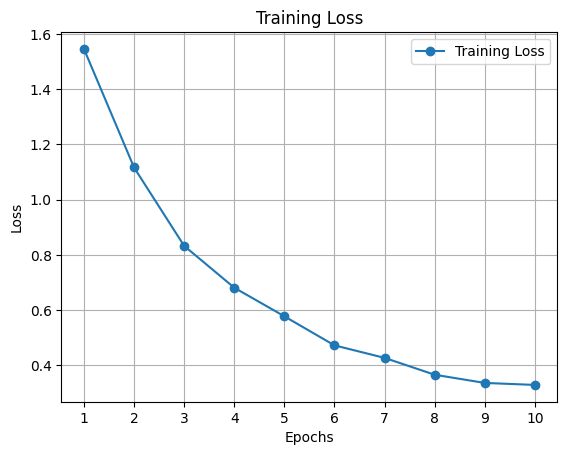

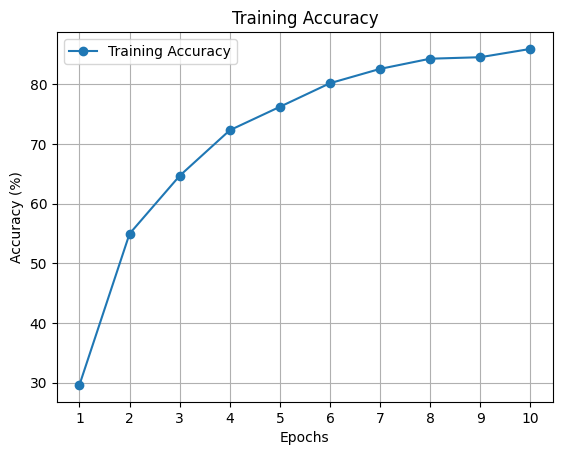

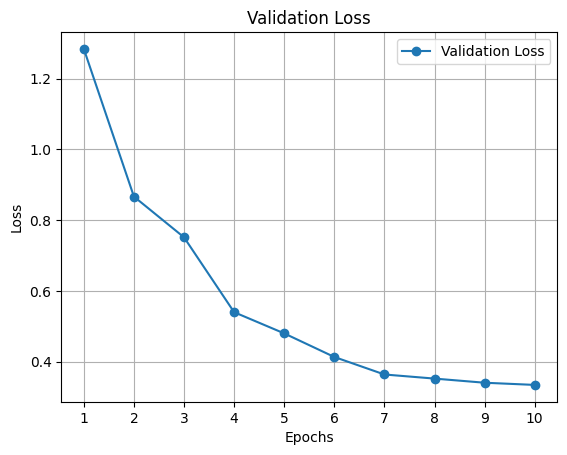

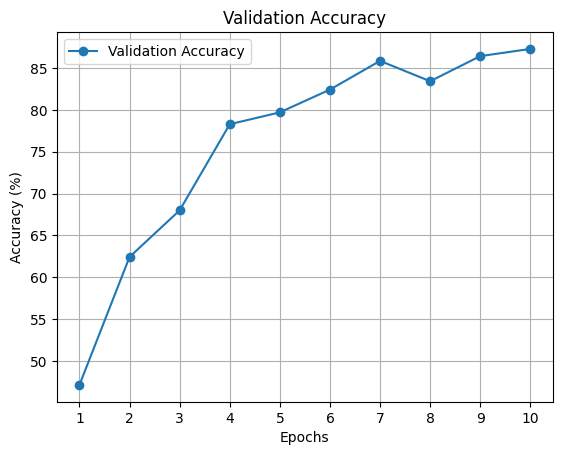

In [ ]:
import matplotlib.pyplot as plt

# Define the epoch values
epochs = range(1, 11)

# Define the training loss and accuracy values
train_loss = [1.5461, 1.1166, 0.8327, 0.6812, 0.5776, 0.4723, 0.4270, 0.3659, 0.3362, 0.3290]
train_accuracy = [29.61, 54.96, 64.68, 72.32, 76.25, 80.21, 82.61, 84.32, 84.57, 85.96]

# Define the validation loss and accuracy values
val_loss = [1.2843, 0.8667, 0.7515, 0.5398, 0.4798, 0.4131, 0.3636, 0.3520, 0.3403, 0.3341]
val_accuracy = [47.14, 62.43, 68.00, 78.29, 79.71, 82.43, 85.86, 83.43, 86.43, 87.29]

# Plot the training loss
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.show()

# Plot the training accuracy
plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.show()

# Plot the validation loss
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.show()

# Plot the validation accuracy
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.show()


# **GAN + ResNet model**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import ImageFolder
import os
from PIL import Image
import torch.nn.functional as F
from torchvision import models

from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the dataset class
class WBCDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = os.listdir(root_dir)  # Get the class names
        for label, class_name in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_name)
            for image_name in os.listdir(class_path):
                self.image_paths.append(os.path.join(class_path, image_name))
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Define transforms
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load dataset
dataset = WBCDataset(root_dir="/content/drive/My Drive/filtered_images", transform=transform)

# Split dataset into training, validation, and test sets
train_size = int(0.8 * len(dataset))
val_size = (len(dataset) - train_size) // 2
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create data loaders for training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Define the Generator
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()

        self.latent_dim = latent_dim
        self.img_shape = img_shape

        self.init_size = img_shape[1] // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 3, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()

        self.img_shape = img_shape

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(3, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = img_shape[1] // 2 ** 4
        self.adv_layer = nn.Linear(128 * ds_size ** 2, 1)

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        return validity

# Define the parameters
latent_dim = 100
img_shape = (3, 64, 64)

# Create the generator and discriminator
generator = Generator(latent_dim, img_shape)
discriminator = Discriminator(img_shape)

# Loss function and optimizer
adversarial_loss = nn.BCEWithLogitsLoss()
generator_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training
num_epochs = 2
for epoch in range(num_epochs):
    # Training loop
    for batch_idx, (real_images, _) in enumerate(train_loader):
        batch_size = real_images.size(0)

        # Train discriminator with real images
        discriminator_optimizer.zero_grad()
        real_labels = torch.ones(batch_size, 1)
        real_outputs = discriminator(real_images)
        real_loss = adversarial_loss(real_outputs, real_labels)
        real_loss.backward()

        # Train discriminator with fake images
        z = torch.randn(batch_size, latent_dim)
        fake_labels = torch.zeros(batch_size, 1)
        fake_images = generator(z)
        fake_outputs = discriminator(fake_images.detach())
        fake_loss = adversarial_loss(fake_outputs, fake_labels)
        fake_loss.backward()
        discriminator_optimizer.step()

        # Train generator
        generator_optimizer.zero_grad()
        z = torch.randn(batch_size, latent_dim)
        fake_images = generator(z)
        validity = discriminator(fake_images)
        generator_loss = adversarial_loss(validity, real_labels)
        generator_loss.backward()
        generator_optimizer.step()

        if batch_idx % 100 == 0:
            print(f"[Epoch {epoch}/{num_epochs}] [Batch {batch_idx}/{len(train_loader)}] [D loss: {real_loss.item() + fake_loss.item()}] [G loss: {generator_loss.item()}]")

# Define the ResNet model
resnet_model = models.resnet18(pretrained=True)
num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_ftrs, len(dataset.classes))

# Loss function and optimizer for the ResNet model
criterion = nn.CrossEntropyLoss()
resnet_optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)

# Training the ResNet model
num_epochs_resnet = 5
for epoch in range(num_epochs_resnet):
    # Training loop
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        resnet_optimizer.zero_grad()
        outputs = resnet_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        resnet_optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch [{epoch+1}/{num_epochs_resnet}], Loss: {running_loss / len(train_loader)}, Accuracy: {(100 * correct / total)}%")

# Evaluation on the validation set
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        outputs = resnet_model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Validation Accuracy: {(100 * correct / total)}%")

# Evaluation on the test set
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = resnet_model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {(100 * correct / total)}%")

# Prediction on unseen images
with torch.no_grad():
    unseen_images, _ = next(iter(test_loader))
    outputs = resnet_model(unseen_images)
    _, predicted = torch.max(outputs, 1)
    print("Predicted Labels:", predicted)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Epoch 0/2] [Batch 0/88] [D loss: 1.388181746006012] [G loss: 0.6919603943824768]
[Epoch 1/2] [Batch 0/88] [D loss: 1.4042892456054688] [G loss: 0.6787929534912109]
Epoch [1/5], Loss: 0.7356267127801072, Accuracy: 73.0%
Epoch [2/5], Loss: 0.3133866665038196, Accuracy: 88.42857142857143%
Epoch [3/5], Loss: 0.24731621821410954, Accuracy: 91.0%
Epoch [4/5], Loss: 0.1643882087982175, Accuracy: 93.96428571428571%
Epoch [5/5], Loss: 0.16070362700107085, Accuracy: 94.57142857142857%
Validation Accuracy: 88.0%
Test Accuracy: 89.14285714285714%
Predicted Labels: tensor([4, 3, 0, 4, 0, 0, 4, 3, 0, 1, 2, 2, 4, 4, 4, 0, 2, 2, 1, 2, 3, 1, 0, 1,
        4, 1, 2, 3, 3, 3, 2, 0])


In [ ]:
# Create a dictionary mapping labels to class names
label_to_class = {i: class_name for i, class_name in enumerate(dataset.classes)}

# Prediction on unseen images
with torch.no_grad():
    unseen_images, _ = next(iter(test_loader))
    outputs = resnet_model(unseen_images)
    _, predicted = torch.max(outputs, 1)
    predicted_classes = [label_to_class[label.item()] for label in predicted]
    print("Predicted Labels:", predicted_classes)

# Print labels and their corresponding classes
for label, class_name in label_to_class.items():
    print(f"Label {label}: Class {class_name}")



Predicted Labels: ['lymphocyte', 'monocyte', 'neutrophil', 'lymphocyte', 'neutrophil', 'neutrophil', 'lymphocyte', 'monocyte', 'neutrophil', 'eosinophil', 'basophil', 'basophil', 'lymphocyte', 'lymphocyte', 'lymphocyte', 'neutrophil', 'basophil', 'basophil', 'eosinophil', 'basophil', 'monocyte', 'eosinophil', 'neutrophil', 'eosinophil', 'lymphocyte', 'eosinophil', 'basophil', 'monocyte', 'monocyte', 'monocyte', 'basophil', 'neutrophil']
Label 0: Class neutrophil
Label 1: Class eosinophil
Label 2: Class basophil
Label 3: Class monocyte
Label 4: Class lymphocyte


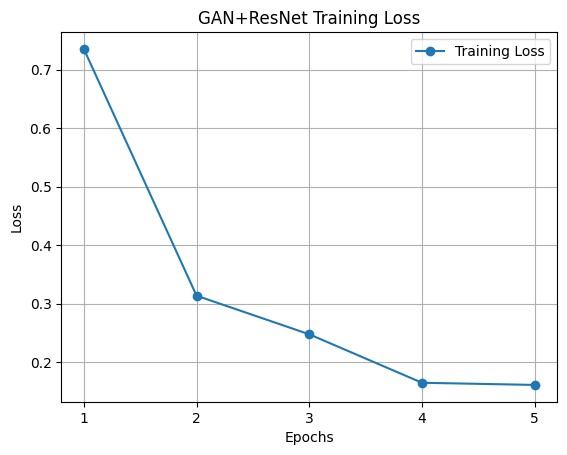

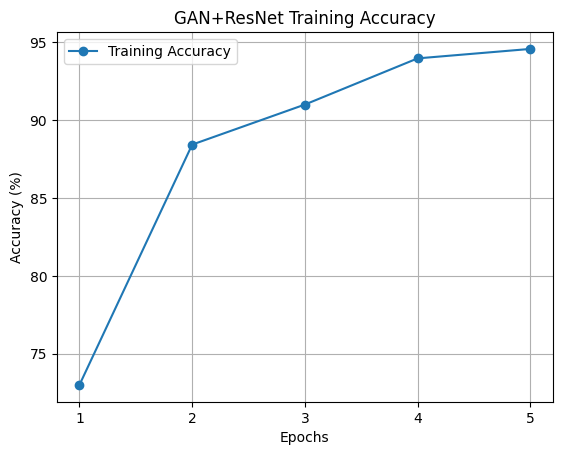

In [ ]:
import matplotlib.pyplot as plt

# Define the epoch values
epochs = range(1, 6)

# Define the training loss and accuracy values
train_loss = [0.7356267127801072, 0.3133866665038196, 0.24731621821410954, 0.1643882087982175, 0.16070362700107085]
train_accuracy = [73.0, 88.42857142857143, 91.0, 93.96428571428571, 94.57142857142857]

# Define the validation accuracy and test accuracy values
val_accuracy = [88.0, 88.0, 88.0, 88.0, 88.0]
test_accuracy = [89.14285714285714, 89.14285714285714, 89.14285714285714, 89.14285714285714, 89.14285714285714]

# Plot the training loss
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.title('GAN+ResNet Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.show()

# Plot the training accuracy
plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o')
plt.title('GAN+ResNet Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.show()
